# Map fungal pathogens
Install packages in new env `conda activate geo_env`

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import seaborn as sns
import re 
import numpy as np

%matplotlib inline

# Get Pathogens 

In [4]:
df_asv = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/berries_harvest_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_asv.shape

(417, 6887)

In [13]:
genus_list = ['Botrytis']

pattern = "|".join(genus_list)
columns_to_keep = [col for col in df_asv.columns if re.search(pattern, col)]
pathogen_df = df_asv[columns_to_keep]
pathogen_df.shape

(417, 9)

In [14]:
collapsed_df = pathogen_df.sum(axis=1).reset_index(name='feature')
collapsed_df = collapsed_df.rename(columns={'index': 'SAMPLE_NAME'})
collapsed_df.shape

(417, 2)

In [15]:
df_md_lavaux = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
df_md_lavaux = df_md_lavaux[['SAMPLE_NAME','Latitude', 'Longitude', 'Year']]
df_md_valais = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Valais_and_Lavaux23.tsv', sep='\t')
df_md_valais = df_md_valais[['SAMPLE_NAME','Latitude', 'Longitude', 'Year']]

df_md_merged = df_md_lavaux.merge(df_md_valais, on=['SAMPLE_NAME','Latitude', 'Longitude', 'Year'], how='outer')
df_md_merged.head()

,SAMPLE_NAME,Latitude,Longitude,Year
0,Lavaux_2021-08-31_bark_Plot4,46.498857,6.708072,2021
1,Lavaux_2021-08-31_bark_Plot5,46.496407,6.708712,2021
2,Lavaux_2021-08-31_bark_Plot9,46.499468,6.712242,2021
3,Lavaux_2021-08-31_bark_Plot11,46.500244,6.706655,2021
4,Lavaux_2021-08-31_bark_Plot12,46.502628,6.704952,2021


In [16]:
df_map = collapsed_df.merge(df_md_merged, on='SAMPLE_NAME')
df_map.head()

,SAMPLE_NAME,feature,Latitude,Longitude,Year
0,Valais_7,0.0,46.091944,7.061944,2023
1,Valais_30,0.0,46.219722,7.271944,2023
2,Valais_2,0.0,46.364444,6.870556,2023
3,Valais_33,0.0,46.219722,7.288611,2023
4,Valais_26,0.0,46.196389,7.225278,2023


In [17]:
# add log2? 
df_map['log2_feature'] = np.log2(df_map['feature'] + 1e-6)
df_map.tail()

,SAMPLE_NAME,feature,Latitude,Longitude,Year,log2_feature
405,Lavaux_2021-09-30_must_Plot18_Row2/Vine7_ID185,0.0,46.494710,6.713255,2021,-19.931569
406,Lavaux_2021-09-30_must_Plot20_Row7/Vine20_ID207,0.0,46.493887,6.720550,2021,-19.931569
407,Lavaux_2021-09-30_must_Plot9_Row11/Vine22_ID54,0.0,46.499468,6.712242,2021,-19.931569
408,Lavaux_2021-09-30_must_Plot9_Row2/Vine10_ID38,0.0,46.499468,6.712242,2021,-19.931569
409,Lavaux_2021-09-30_must_Plot9_Row10/Vine31_ID53,0.0,46.499468,6.712242,2021,-19.931569


In [18]:
# Convert to GeoDataFrame
gdf_samples = gpd.GeoDataFrame(df_map, geometry=gpd.points_from_xy(df_map.Longitude, df_map.Latitude), crs="EPSG:4326")

# Convert to Web Mercator (needed for contextily basemap)
gdf_samples = gdf_samples.to_crs(epsg=3857)


# All samples - Lavaux & Valais

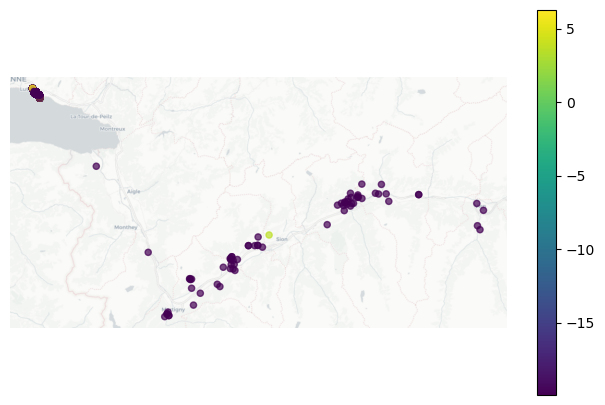

In [19]:
# Plot
fig, ax = plt.subplots(figsize=(8,5))
gdf_samples.plot(ax=ax, column='log2_feature', cmap='viridis', markersize=20, legend=True, alpha=0.7)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)  

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)

plt.show()

# Lavaux only

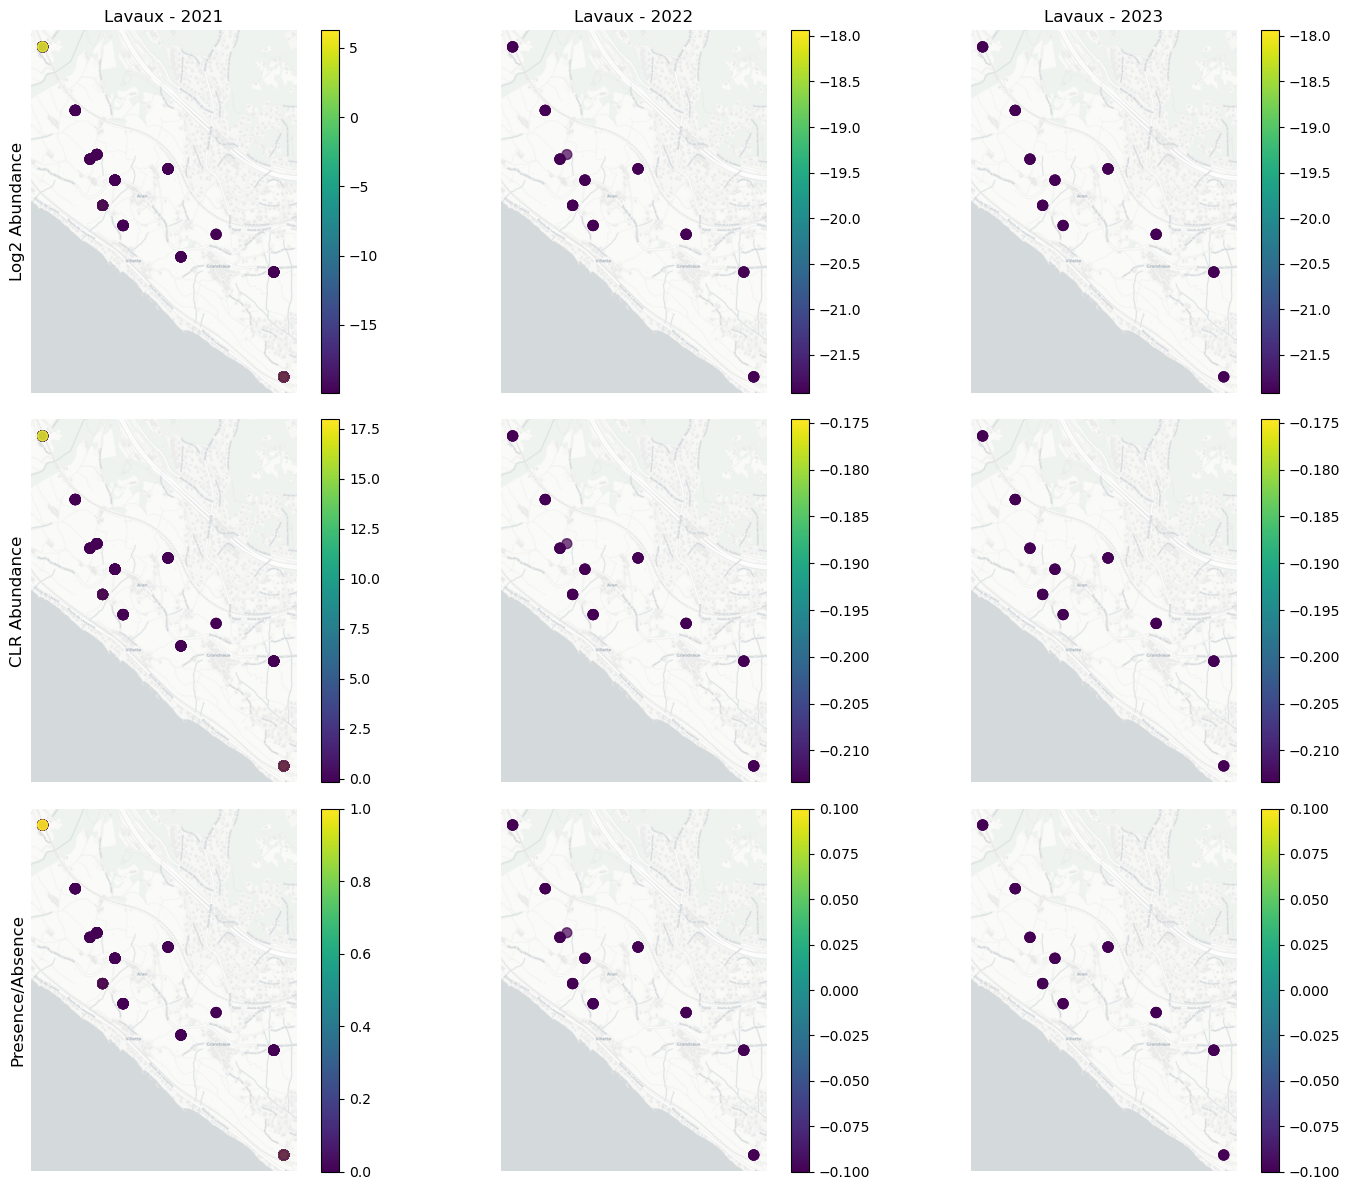

In [20]:
# Filter for samples that start with "Lavaux_"
df_lavaux = df_map[df_map['SAMPLE_NAME'].str.startswith('Lavaux_')].copy()

# Avoid log(0) by adding a small constant
df_lavaux['log2_feature'] = np.log2(df_lavaux['feature'] + 1e-6)

# CLR transformation (Centered Log-Ratio)
df_lavaux['clr_feature'] = np.log(df_lavaux['feature'] + 1e-6) - np.log(df_lavaux['feature'] + 1e-6).mean()

# Binary transformation (Presence = 1, Absence = 0)
df_lavaux['binary_feature'] = (df_lavaux['feature'] > 0).astype(int)

# Convert to GeoDataFrame
gdf_lavaux = gpd.GeoDataFrame(df_lavaux, geometry=gpd.points_from_xy(df_lavaux.Longitude, df_lavaux.Latitude), crs="EPSG:4326")
gdf_lavaux = gdf_lavaux.to_crs(epsg=3857)  # Convert to Web Mercator

# Define years and transformations
years = [2021, 2022, 2023]
transformations = ['log2_feature', 'clr_feature', 'binary_feature']
titles = ['Log2 Abundance', 'CLR Abundance', 'Presence/Absence']

# Create 3 rows (transformations) x 3 columns (years)
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

for row, transform in enumerate(transformations):
    for col, year in enumerate(years):
        ax = axes[row, col]
        
        # Subset for the given year
        gdf_year = gdf_lavaux[gdf_lavaux['Year'] == year]
        
        # Plot
        gdf_year.plot(ax=ax, column=transform, cmap='viridis', markersize=50, legend=True, alpha=0.7)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)

        # Formatting
        if col == 0:
            ax.set_ylabel(titles[row], fontsize=12)
        if row == 0:
            ax.set_title(f"Lavaux - {year}", fontsize=12)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)

plt.tight_layout()
plt.show()


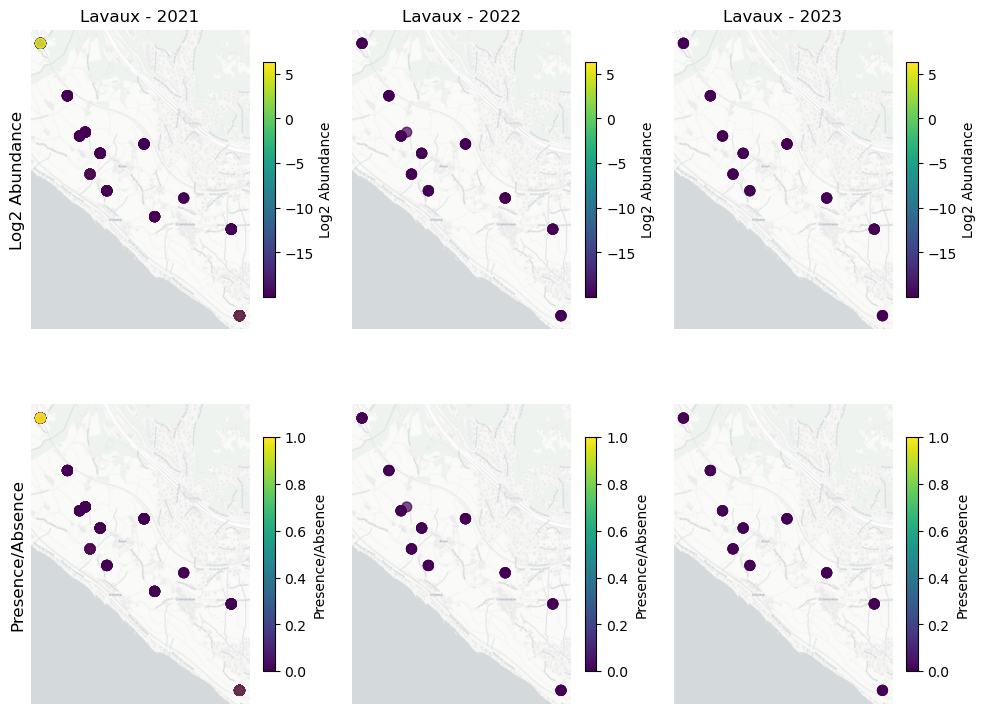

In [31]:
# Filter for samples that start with "Lavaux_"
df_lavaux = df_map[df_map['SAMPLE_NAME'].str.startswith('Lavaux_')].copy()

# Avoid log(0) by adding a small constant
df_lavaux['log2_feature'] = np.log2(df_lavaux['feature'] + 1e-6)

# Binary transformation (Presence = 1, Absence = 0)
df_lavaux['binary_feature'] = (df_lavaux['feature'] > 0).astype(int)

# Convert to GeoDataFrame
gdf_lavaux = gpd.GeoDataFrame(df_lavaux, geometry=gpd.points_from_xy(df_lavaux.Longitude, df_lavaux.Latitude), crs="EPSG:4326")
gdf_lavaux = gdf_lavaux.to_crs(epsg=3857)  # Convert to Web Mercator

# Define years and transformations
years = [2021, 2022, 2023]
transformations = ['log2_feature', 'binary_feature']
titles = ['Log2 Abundance',  'Presence/Absence']

# Create 3 rows (transformations) x 3 columns (years)
fig, axes = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

for row, transform in enumerate(transformations):
    for col, year in enumerate(years):
        ax = axes[row, col]
        
        # Subset for the given year
        gdf_year = gdf_lavaux[gdf_lavaux['Year'] == year]
        
        # Plot
        gdf_year.plot(ax=ax, column=transform, cmap='viridis', markersize=50, legend=False, alpha=0.7)
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)

        # Add colorbar with smaller size
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=gdf_lavaux[transform].min(), vmax=gdf_lavaux[transform].max()))
        sm._A = []  # Empty array for colorbar
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6)  # Adjust shrink factor here
        cbar.set_label(titles[row], fontsize=10)

        # Formatting
        if col == 0:
            ax.set_ylabel(titles[row], fontsize=12)
        if row == 0:
            ax.set_title(f"Lavaux - {year}", fontsize=12)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)

plt.tight_layout()
plt.show()
